In [2]:
import pandas
import numpy
#from LiarLiar import arePantsonFire

import seaborn
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

from torch.utils.data import DataLoader
import torch

def create_glove_dict(path_to_text:str): # 0.75 Marks
    """
    Create the dictionary containing word and corresponding vector.
    :param path_to_text: Path to Glove embeddings.
    """
    embeddings = {}
    with open(path_to_text,'r') as f:
        lines = f.readlines()
        for line in lines:
            word = line.split(' ')[0]
            embedding = line.split(' ')[1:]
            embedding = [float(i) for i in embedding]
            embeddings[word] = embedding
    '''
    Your code goes here.
    '''
    return embeddings

def get_max_length(dataframe: pandas.DataFrame, column_number: int): # 0.75 Marks
    """
    :param dataframe: Pandas Dataframe
    :param column_number: Column number you want to get max value from
    :return: max_length: int
    """
    max_length = 0
    for sent in dataframe[column_number]:
        # print(i)
        l = len(word_tokenize(sent.lower()))
        if l >= max_length:
            max_length = l
    # print(len(word_tokenize('THIS IS A SAMPLE Sentence'.lower())))
    '''
    Your code goes here
    '''
    return max_length

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
import torch
from torch.utils.data import Dataset

import numpy
import pandas
from nltk import word_tokenize

#from utils import get_max_length, create_glove_dict


class dataset(Dataset):
    def __init__(self, path_to_glove='/content/drive/My Drive/Colab Notebooks/glove.6B.200d.txt',
                 embedding_dim=200, prep_Data_from = 'train', purpose='train_model'):
        """
        NOTE-
        Beware of NaNs, drop them beforehand

        Dataset is the Liar Dataset. The description of the data can be found here -
        "Liar, Liar Pants on Fire: A New Benchmark Dataset for Fake News Detection - https://arxiv.org/abs/1705.00648"
        Download the dataset from - https://github.com/Tariq60/LIAR-PLUS
        Find the Glove vectors at https://nlp.stanford.edu/projects/glove/ and download the 822MB one.
        It contains 50d,100d, 200d and 300d vectors.
        300d with 400K vocab takes around 1.5GB RAM, choose file according to your system.
        We have prepared test cases using the 200d vectors.

        :param path_to_glove: path to the desired glove vector file. File would be a .txt file
        :param embedding_dim: The dimension of vector you are choosing.
        :param prep_Data_from: Chose file from which you wanna prep data.
        :param purpose: This is only used by the test.py file. This parameter should not concern you. When making your dataloaders, DO NOT pass this parameter.
        """
        #assert prep_Data_from in ['train', 'test', 'val']
        assert purpose in ['train_model', 'test_class']

        if purpose == 'train_model':
            path_to_train = 'train2.tsv'
            path_to_val = 'val2.tsv'
            path_to_test = 'test2.tsv'
        else:
            path_to_train = 'sample_train.tsv'
            path_to_test = 'sample_test.tsv'
            path_to_val = 'sample_val.tsv'

        train_Dataframe = pandas.read_csv(path_to_train, sep='\t', header=None).dropna()
        test_Dataframe = pandas.read_csv(path_to_test, sep='\t', header=None).dropna()
        val_Dataframe = pandas.read_csv(path_to_val, sep='\t', header=None).dropna()

        self.embeddings = create_glove_dict(path_to_glove)
        self.embedding_dim = embedding_dim
        self.dataframe = pandas.concat([train_Dataframe, test_Dataframe, val_Dataframe])

        self.justification_max = get_max_length(self.dataframe, 15)
        self.statement_max = get_max_length(self.dataframe, 3)

        if prep_Data_from == 'train':
            self.dataframe = train_Dataframe
        elif prep_Data_from == 'val':
            self.dataframe = val_Dataframe
        elif prep_Data_from == 'test':
            self.dataframe = test_Dataframe

        del train_Dataframe, test_Dataframe, val_Dataframe

        self.labels = {"true": 0,
                       "mostly-true": 1,
                       "half-true": 2,
                       "barely-true": 3,
                       "false": 4,
                       "pants-fire": 5}

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx): # 1.25 Mark
        data_dict = {}

        statement = word_tokenize(self.dataframe.iloc[idx,3].lower())
        justification = word_tokenize(self.dataframe.iloc[idx,15].lower())
        label = torch.Tensor([self.labels[self.dataframe.iloc[idx,2]]])
        vectorized_statement = numpy.zeros((self.embedding_dim,self.statement_max))
        vectorized_justification = numpy.zeros((self.embedding_dim,self.justification_max))

        for pos, word in enumerate(statement):
            try:
                vectorized_statement[:,pos] = self.embeddings[word]

            except KeyError:
                print('Word not in Vocab. Placing it at origin')
                continue

        for pos, word in enumerate(justification):
            try:
                vectorized_justification[:,pos] = self.embeddings[word]
            except KeyError:
                print('Word not in Vocab. Placing it at origin')
                continue
        vectorized_justification = torch.Tensor(vectorized_justification)
        vectorized_statement = torch.Tensor(vectorized_statement)

        # 9 - Barely true counts
        # 10 - False counts
        # 11 half true counts
        # 12 mostly true counts
        # 13 pants on fire count

        credit_history = torch.Tensor([self.dataframe.iloc[idx,12],self.dataframe.iloc[idx,11],self.dataframe.iloc[idx,9],self.dataframe.iloc[idx,10],self.dataframe.iloc[idx,13]])


        data_dict['statement'] = vectorized_statement
        data_dict['justification'] = vectorized_justification
        data_dict['label'] = label
        data_dict['credit_history'] = credit_history

        del vectorized_statement, vectorized_justification, label, credit_history  # just free up some memory
        return data_dict

    def get_max_lenghts(self):
        return self.statement_max, self.justification_max

    def get_Data_shape(self):
        return self.dataframe.shape

In [4]:
import torch.nn as nn

class ConvEncoder(nn.Module):
    def __init__(self, input_dim, num_layers=3):
        """
        The convolutional Encoder layer.
        Model based on the paper "Convolutional Sequence to Sequence Learning - https://arxiv.org/pdf/1705.03122.pdf"
        :param input_dim: input dimension of the tensor
        :param num_layers: Number of convolutional you desire to stack on top of each other
        """
        super(ConvEncoder, self).__init__()
        self.convolutions = self.get_convolutions(input_dim=input_dim, num_layers=num_layers)

    def forward(self, source): # 1 Mark
        """
        Remember, we have multiple convolutional layers, for iterate over them.
        :param source: Input tensor for the forward pass.
        """
        obtained_output = source.clone()
        for conv in self.convolutions:
            # Your code goes here.
            out = conv(obtained_output)
            out = nn.functional.glu(out, dim=1)
            # Your code goes here.
            obtained_output += out

        return source

    def get_convolutions(self, input_dim, num_layers=3): # 0.5 Marks
        """
        :param input_dim: input dimension
        :param num_layers: Number of convolutional you desire to stack on top of each other
        :return: nn.ModuleList()
        """
        return nn.ModuleList([nn.Conv1d(input_dim,2*input_dim,3,1,1) for i in range(num_layers)])

In [5]:
import torch
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, hid_dim, n_heads):
        """
        The multihead attention block as described in the paper Attention is All you need - https://arxiv.org/abs/1706.03762
        :param hid_dim:
        :param n_heads:
        """
        super(MultiHeadAttention, self).__init__()
        self.attention_heads = n_heads
        # Define convolution for query, key and value and one for output. Kernel 3, stride 1, padding 1 and output convolution should be an identity kernel.
        self.conv_query, self.conv_key, self.conv_value, self.conv_output = self.get_layers(hid_dim=hid_dim)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim//n_heads]))
        self.per_head_dim = hid_dim//n_heads



    def forward(self, query, key, value): #query is the hidden state from our encoder, value is the description

        batch_size = query.shape[0]
        Q = self.conv_query(query)
        K = self.conv_key(key)
        V = self.conv_value(value)

        #Q = [batch_Size, hidden_dim, query_len]
        #K = [batch_Size, hidden_dim, key_len]
        #V = [batch_Size, hiddem_dim, value_len]

        Q = Q.view(batch_size, -1, self.attention_heads, self.per_head_dim).permute(0, 2, 1, 3)
        # Query shape is [batch, seq_len, num_heads, dim_per_head]
        K = K.view(batch_size, -1, self.attention_heads, self.per_head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.attention_heads, self.per_head_dim).permute(0, 2, 1, 3)

        energy = torch.matmul(Q, K.permute(0, 1, 3, 2))
        #shape of energy is [batch_Size, query_len, key_len]

        attention = torch.softmax(energy, dim=-1)
        #attention shape is [batch_Size, n_heads, query_Len, key_len]

        output = torch.matmul(attention, V)
        output = output.view(batch_size, self.attention_heads*self.per_head_dim, -1)
        output = output+query # The residual connection
        output = nn.functional.layer_norm(output, [output.shape[0], output.shape[1], output.shape[2]])
        # shape of output is [batch, hidden_dim, query_len]
        output = self.conv_output(output)
        return output

    def get_layers(self, hid_dim): # 0.5 Marks
        """
        Get the for multihead attention using this function
        :param hid_dim: Hidden Dimension
        """
        conv_query = nn.Conv1d(hid_dim,hid_dim,3,1,1)
        conv_key = nn.Conv1d(hid_dim,hid_dim,3,1,1)
        conv_value = nn.Conv1d(hid_dim,hid_dim,3,1,1)
        conv_output = nn.Conv1d(hid_dim,hid_dim,1,1,0)
        return conv_query,conv_key,conv_value,conv_output

class PositionFeedforward(nn.Module):

    def __init__(self, hid_dim, feedForward_dim):
        """
        Implements positionFeedForward layer. Expected Input shape is [batch_size, hidden_dim, length]
        :param hid_dim: hidden dim
        :param feedForward_dim: feed forward dim, this is generally way larger than hidden dim
        :param batch: batch size
        :param length: length of sequence.
        """

        super(PositionFeedforward, self).__init__()
        layers = self.get_layers(hid_dim=hid_dim, feedForward_dim=feedForward_dim)
        self.conv1 = layers[0]
        self.conv2 = layers[1]

    def forward(self, x): # 1 Mark
        # Your code goes here.
        # print(x.size())
        temp = x
        x = self.conv1(x)
        # print(x.size())

        x = self.conv2(x)
        # print(x.size())

        x = torch.add(x,temp)
        return nn.functional.layer_norm(x, [x.shape[0], x.shape[1], x.shape[2]])

    def get_layers(self, hid_dim, feedForward_dim): # 0.5 Mark
        """
        Used to get the layers of the PositionFeedForward Block
        :param hid_dim: Hidden Dimension
        :feedForward_dim: FeedForward Dimension
        """
        conv1 = nn.Conv1d(hid_dim,feedForward_dim,3,1,1)
        conv2 = nn.Conv1d(feedForward_dim,hid_dim,1,1)
        return [conv1,conv2]

In [6]:
import torch
import torch.nn as nn

#from ConvS2S import ConvEncoder
#from Attention import MultiHeadAttention, PositionFeedforward

class Encoder(nn.Module): # 1 Mark
    def __init__(self, conv_layers, hidden_dim, feed_forward_dim=2048):
        super(Encoder, self).__init__()
        # Your code here
        self.conv = ConvEncoder(input_dim = hidden_dim,num_layers = conv_layers)
        self.attention = MultiHeadAttention(hid_dim = hidden_dim,n_heads = 16)
        self.feed_forward = PositionFeedforward(hid_dim = hidden_dim,feedForward_dim = feed_forward_dim)
        # print(self.ce)
        # print(self.mha)
        # print(self.pff)
        #
    def forward(self, input):
        """
        Forward Pass of the Encoder Class
        :param input: Input Tensor for the forward pass.
        """
        # Your code here
        # print(input)
        out = self.conv(input)
        # print(input)
        out = self.attention(out,out,out)
        # print(input)
        out = self.feed_forward(out)
        # print("INSIDE FORWARD OF ENC")
        return out

In [7]:
class arePantsonFire(nn.Module):

    def __init__(self, sentence_encoder: Encoder, explanation_encoder: Encoder, multihead_Attention: MultiHeadAttention,
                 position_Feedforward: PositionFeedforward, hidden_dim: int, max_length_sentence,
                 max_length_justification, input_dim, device='cuda:0'):
        """
        If you wish to shift on cpu pass device as 'cpu'
        """

        super(arePantsonFire, self).__init__()
        self.device = device

        self.sentence_pos_embedding = nn.Embedding(max_length_sentence, hidden_dim)
        self.justification_pos_embedding = nn.Embedding(max_length_justification, hidden_dim)

        self.sentence_encoder = sentence_encoder
        self.explanation_encoder = explanation_encoder
        self.attention = multihead_Attention
        self.position_feedforward = position_Feedforward

        self.upscale_conv, self.first_conv, self.flatten_conv = self.get_convolutions(input_dim=input_dim, hidden_dim=hidden_dim)
        self.linear1, self.linear2, self.bilinear, self.classifier = self.get_linears_layers(max_length_sentence=max_length_sentence)

    def forward(self, sentence, justification, credit_history): # 1 Marks

        sentence_pos = torch.arange(0, sentence.shape[2]).unsqueeze(0).repeat(sentence.shape[0],1).to(self.device).long()
        justification_pos = torch.arange(0, justification.shape[2]).unsqueeze(0).repeat(justification.shape[0], 1).to(self.device).long()

        sentence = self.upscale_conv(sentence)
        sentence = sentence + self.sentence_pos_embedding(sentence_pos).permute(0, 2, 1)

        justification = self.upscale_conv(justification)
        justification = justification + self.justification_pos_embedding(justification_pos).permute(0, 2, 1)

        # Your code goes here
        encoded_sentence = self.sentence_encoder(sentence)
        encoded_justification = self.explanation_encoder(sentence)
        attention_output = self.attention(encoded_sentence,encoded_justification,encoded_justification)
        output = self.position_feedforward(attention_output)
        output = self.first_conv(output)
        output = nn.ReLU()(output)
        output = self.flatten_conv(output)
        output = nn.Flatten()(output)
        output = self.linear1(output)
        output = self.linear2(output)
        output = self.bilinear(output,credit_history)
        output = self.classifier(output)
        return output

    def get_convolutions(self, input_dim, hidden_dim): # 0.5 Marks
    # Your code here
        upscale_conv = nn.Conv1d(input_dim,hidden_dim,1,1)
        first_conv = nn.Conv1d(hidden_dim,hidden_dim//2,3,1,1)
        flatten_conv = nn.Conv1d(hidden_dim//2,1,5,1,2)

        return upscale_conv,first_conv,flatten_conv

    def get_linears_layers(self, max_length_sentence): # 0.5 Marks
    # Your code goes here
        linear1 = nn.Linear(max_length_sentence,max_length_sentence//4)
        linear2 = nn.Linear(max_length_sentence//4,6)
        bilinear = nn.Bilinear(6,5,12)
        classifier = nn.Linear(12,6)
        return linear1,linear2,bilinear,classifier

In [8]:
def visualize_Attenion(attention_matrix: numpy.ndarray):
    """
    Visualizes multihead attention. Expected input shape to [n_heads, query_len, key_len]
    :param attention_matrix:
    :return:
    """
    assert len(attention_matrix.shape) == 3

    for head in range(attention_matrix.shape[0]):
        seaborn.heatmap(attention_matrix[head])
    plt.show()

def infer(model: arePantsonFire, dataloader:DataLoader):
    """
    Use for inferencing on the trained model. Assumes batch_size is 1.
    :param model: trained model.
    :param dataloader: Test Dataloader
    :return:
    """
    labels = {0: "true", 1: "mostly true", 2: "half true", 3: "barely true" , 4: "false", 5: "pants on fire"}
    model.eval()
    correct = 0
    wrong = 0
    for _, data in enumerate(dataloader):
        statement = data['statement'].cuda()
        justification = data['justification'].cuda()
        credit_history = data['credit_history'].cuda()
        label = data['label'].cuda()

        prediction = model(statement, justification, credit_history)
        if torch.argmax(prediction).item() == label.item():
            print("Correct Prediction")
            correct+=1
        else:
            print("wrong prediction")
            wrong+=1

        print(labels[torch.argmax(prediction, dim=1).item()])

        print('-------------------------------------------------------------------------------------------------------')
    print(correct/_)
    print(wrong/_)

In [9]:
import matplotlib.pyplot as plt

def trainer(model, train_dataloader, val_dataloader, num_epochs, path_to_save='/home/harsh/Downloads/NNFL_A2',
          checkpoint_path='/home/harsh/Downloads/NNFL_A2',
          checkpoint=100, train_batch=1, test_batch=1, device='cuda:0'): # 2 Marks.
    """
    Everything by default gets shifted to the GPU. Select the device according to your system configuration
    If you do no have a GPU, change the device parameter to "device='cpu'"
    :param model: the Classification model..
    :param train_dataloader: train_dataloader
    :param val_dataloader: val_Dataloader
    :param num_epochs: num_epochs
    :param path_to_save: path to save model
    :param checkpoint_path: checkpointing path
    :param checkpoint: when to checkpoint
    :param train_batch: 1
    :param test_batch: 1
    :param device: Defaults on GPU, pass 'cpu' as parameter to run on CPU.
    :return: None
    """
    torch.backends.cudnn.benchmark = True #Comment this if you are not using a GPU...
    # set the network to training mode.
    model.to(device)  # if gpu available otherwise comment this line.
    # your code goes here.
    criterion = nn.CrossEntropyLoss().cuda()
    optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3)
    max_accuracy = None
    training_loss = []
    training_acc = []
    val_loss = []
    val_acc = []
    for epoch in range(1,num_epochs+1):
        if (epoch%100)==0:
            print("checkpoint")
            torch.save({
                'epoch':epoch,
                'optimizer': optimizer.state_dict(),
                'model': model.state_dict(),
                'train_loss': training_loss,
                'val_loss': val_loss,
                'train_acc' : training_acc,
                'val_acc' : val_acc
            }, checkpoint_path+'/checkpoint.pt')
            exit(10)
        model.train()
        epoch_train_loss = 0
        epoch_train_acc = 0
        for _,data in enumerate(train_dataloader):
            print("training")
            optimizer.zero_grad()
            statement = data['statement'].to(device)
            justification = data['justification'].to(device)
            label = data['label'].to(device)
            credit_history = data['credit_history'].to(device)

            prediction = model(statement,justification,credit_history)
            # print(prediction,label)
            loss = criterion(prediction,label.long().squeeze(1))
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
            __,predicted = torch.max(prediction.data,1)
            epoch_train_acc += (predicted == label).sum().item()

            # print(label,prediction)
        training_loss.append(epoch_train_loss/_)
        training_acc.append(epoch_train_acc/_)
        with torch.no_grad():
            model.eval()
            epoch_val_loss = 0
            epoch_val_acc = 0
            for _,data in enumerate(val_dataloader):
                print("validating")
                statement = data['statement'].to(device)
                justification = data['justification'].to(device)
                label = data['label'].to(device)
                credit_history = data['credit_history'].to(device)

                prediction = model(statement,justification,credit_history)
                loss = criterion(prediction,label.long().squeeze(1))
                epoch_val_loss += loss.item()
                __,predicted = torch.max(prediction.data,1)
                epoch_val_acc += (predicted == label).sum().item()
            val_loss.append(epoch_val_loss/_)
            val_acc.append(epoch_val_acc/_)

            if max_accuracy is None:
                max_accuracy = epoch_val_acc/_
            else:
                if (epoch_val_acc/_) > max_accuracy:
                    print('saving at validation acc= ', epoch_acc_val/_)
                    torch.save(model.state_dict(), path_to_save+'/model.pth')

    plt.plot(training_acc)
    plt.plot(val_acc)
    plt.plot(training_loss)
    plt.plot(val_loss)
    plt.show()


In [ ]:
from torch.utils.data import DataLoader

# Your code goes here.
liar_dataset_train = dataset(prep_Data_from = 'train')
liar_dataset_val = dataset(prep_Data_from = 'val')
max_length_sentence,max_length_justification = liar_dataset_train.get_max_lenghts()

dataloader_train = DataLoader(liar_dataset_train,batch_size=5)
dataloader_val = DataLoader(liar_dataset_val,batch_size=2)

statement_encoder = Encoder(conv_layers = 5, hidden_dim = 512)
justification_encoder = Encoder(conv_layers = 5, hidden_dim = 512)

multiheadAttention = MultiHeadAttention(hid_dim = 512,n_heads=32)
positionFeedForward = PositionFeedforward(hid_dim = 512, feedForward_dim=2048)

model = arePantsonFire(statement_encoder,justification_encoder,multiheadAttention,positionFeedForward,512,max_length_sentence,max_length_justification,input_dim = liar_dataset_train.embedding_dim)

trainer(model,dataloader_train,dataloader_val,num_epochs = 1,train_batch=1,test_batch=1)
# Do not change module_list , otherwise no marks will be awarded
module_list = [liar_dataset_train, liar_dataset_val, dataloader_train, dataloader_val, statement_encoder, justification_encoder, multiheadAttention, positionFeedForward, model]
del  liar_dataset_val, liar_dataset_train, dataloader_train, dataloader_val


liar_dataset_test = dataset(prep_Data_from='test')
test_dataloader = DataLoader(dataset=liar_dataset_test, batch_size=1)
infer(model=model, dataloader=test_dataloader)

In [10]:
from torch.utils.data import DataLoader

# Your code goes here.
liar_dataset_train = dataset(prep_Data_from = 'train2.tsv')
liar_dataset_val = dataset(prep_Data_from = 'val2.tsv')
max_length_sentence,max_length_justification = liar_dataset_train.get_max_lenghts()

In [11]:
dataloader_train = DataLoader(liar_dataset_train,batch_size=1)
dataloader_val = DataLoader(liar_dataset_val,batch_size=1)

In [12]:
statement_encoder = Encoder(conv_layers = 5, hidden_dim = 512)
justification_encoder = Encoder(conv_layers = 5, hidden_dim = 512)

In [13]:
multiheadAttention = MultiHeadAttention(hid_dim = 512,n_heads=32)
positionFeedForward = PositionFeedforward(hid_dim = 512, feedForward_dim=2048)

In [14]:
model = arePantsonFire(statement_encoder,justification_encoder,multiheadAttention,positionFeedForward,512,max_length_sentence,max_length_justification,input_dim = liar_dataset_train.embedding_dim)

Streaming output truncated to the last 5000 lines.
validating
validating
validating
validating
validating
Word not in Vocab. Placing it at origin
validating
validating
Word not in Vocab. Placing it at origin
validating
validating
validating
validating
validating
validating
validating
validating
Word not in Vocab. Placing it at origin
validating
validating
Word not in Vocab. Placing it at origin
Word not in Vocab. Placing it at origin
Word not in Vocab. Placing it at origin
validating
Word not in Vocab. Placing it at origin
Word not in Vocab. Placing it at origin
Word not in Vocab. Placing it at origin
Word not in Vocab. Placing it at origin
validating
validating
Word not in Vocab. Placing it at origin
validating
Word not in Vocab. Placing it at origin
validating
Word not in Vocab. Placing it at origin
validating
Word not in Vocab. Placing it at origin
Word not in Vocab. Placing it at origin
Word not in Vocab. Placing it at origin
validating
validating
validating
Word not in Vocab. Plac

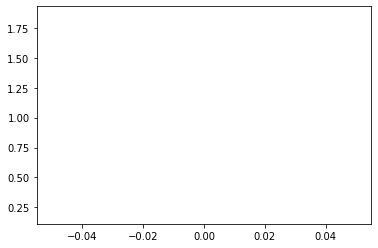

In [15]:
trainer(model,dataloader_train,dataloader_val,num_epochs = 1,train_batch=1,test_batch=1)

In [ ]:
# Do not change module_list , otherwise no marks will be awarded
module_list = [liar_dataset_train, liar_dataset_val, dataloader_train, dataloader_val, statement_encoder, justification_encoder, multiheadAttention, positionFeedForward, model]
del  liar_dataset_val, liar_dataset_train, dataloader_train, dataloader_val


liar_dataset_test = dataset(prep_Data_from='test2.tsv')
test_dataloader = DataLoader(dataset=liar_dataset_test, batch_size=1)
infer(model=model, dataloader=test_dataloader)